# Basic Example of Groundwater Modeling with MODFLOW 6 and Flopy
Based on:
https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3_mf6_tutorial.ipynb

In [1]:
#%ls ..\Exe

import os, flopy

#Going up to the example directory
exampleDir = os.path.dirname(os.getcwd())

simName = 'mf6uzfexamplesim'
simPath = exampleDir + '\Simulation'
exeName = exampleDir + '\Exe\mf6.exe'

sim = flopy.mf6.MFSimulation(sim_name=simName,
                            version='mf6', exe_name=exeName,
                            sim_ws=simPath)

Directory structure already exists for simulation path C:\Users\USER\Documents\Infohataris\BasicExampleMODFLOWUZFFlopy\Simulation


## Model creation and solver options

In [2]:
modelName='mf6uzfexample'
model = flopy.mf6.MFModel(sim,modelname=modelName,model_nam_file=modelName+'.nam')

In [3]:
#creation of a Iterative Model Solution (IMS)
imsPackage = flopy.mf6.ModflowIms(sim, print_option='ALL',
                                   complexity='SIMPLE', outer_hclose=0.00001,
                                   outer_maximum=50, under_relaxation='NONE',
                                   inner_maximum=30, inner_hclose=0.00001,
                                   linear_acceleration='CG',
                                   preconditioner_levels=7,
                                   preconditioner_drop_tolerance=0.01,
                                   number_orthogonalizations=2)

In [4]:
#register solution to the sim
sim.register_ims_package(imsPackage,[modelName])

## Definition of temporal discretization

1 Steady state period of 1s 1 Transient period of 86400s

In [5]:
#Example temporal discretization in MODFLOW 6
tdis = flopy.mf6.ModflowTdis(sim, time_units='seconds', nper=2,
                            perioddata=((1.0,1,1.0),(86400.0,24,1.0)))

## Definition of spatial discretization

In [6]:
disPackage = flopy.mf6.ModflowGwfdis(model, length_units='METERS', 
                                    nlay=2, nrow=20, ncol=20,
                                     delr=4, delc=4, 
                                     top = 100.0, botm=[80.0, 60.0])

## Definition of hydraulic conductivity

In [7]:
#hydraulic conductivity constant for each layer
layerStorageTypes = [flopy.mf6.data.mfdata.DataStorageType.internal_constant, 
                       flopy.mf6.data.mfdata.DataStorageType.internal_constant]
#definition of the empty data type, please note that default value is 1e-5
kTemplate = flopy.mf6.ModflowGwfnpf.k.empty(model, True, layerStorageTypes, 1e-5)

#change constant value of layer 0 and 1
kTemplate[0] = 3.5e-4
kTemplate[1] = 7e-5
print(kTemplate)

#create a NFP package with the kTemplate
npfPackage = flopy.mf6.ModflowGwfnpf(model, save_flows=True, icelltype=1, k=kTemplate)

[0.00035, 7e-05]


## Definition of initial conditions

In [8]:
#define initial heads for model to 99
icPackage = flopy.mf6.ModflowGwfic(model,strt=99)

## Definition of storage parameters

In [9]:
#define dynamic hydraulic parameters, the first layer is convertible and the second is confined
stoPackage = flopy.mf6.ModflowGwfsto(model, save_flows=True, iconvert=[1,0], 
                                     ss=1e-5, sy=0.15, steady_state={0:True}, transient={1:True}) #

## Definition of Constant Head Package

In [10]:
stress_period_data = {0:[
    [[0, 0, 0], 95.1],
    [[0, 1, 0], 95.1],
    [[0, 2, 0], 95.1],
    [[0, 3, 0], 95.1],
    [[0, 4, 0], 95.1],
    [[0, 5, 0], 95.1],
    [[0, 6, 0], 95.1],
    [[0, 7, 0], 95.1],
    [[0, 8, 0], 95.1],
    [[0, 9, 0], 95.1],
    [[0, 10, 19], 99.1],
    [[0, 11, 19], 99.1],
    [[0, 12, 19], 99.1],
    [[0, 13, 19], 99.1],
    [[0, 14, 19], 99.1],
    [[0, 15, 19], 99.1],
    [[0, 16, 19], 99.1],
    [[0, 17, 19], 99.1],
    [[0, 18, 19], 99.1],
    [[0, 19, 19], 99.1],
    ]
    }

chdPackage = flopy.mf6.ModflowGwfchd(model, stress_period_data=stress_period_data)

## Definition of Well Package

In [11]:
#definition of Wel boundary condition in two layers 
maxbound = 2
#define two wells pumping fron 5 to 10 l/s in two layers
welPeriod = flopy.mf6.ModflowGwfwel.stress_period_data.empty(model, maxbound=maxbound, boundnames=True, stress_periods=[0,1])
# define the two wells for stress period one
welPeriod[0][0] = ((0,8,8), -0.020, 'First Well')
welPeriod[0][1] = ((1,12,16), -0.025, 'Second Well')
# define the two wells for stress period two
welPeriod[1][0] = ((0,8,8), -0.050, 'First Well')
welPeriod[1][1] = ((1,12,16), -0.040, 'Second Well')
# build the well package
welPackage = flopy.mf6.ModflowGwfwel(model, stress_period_data=welPeriod, boundnames=True, save_flows=True)

In [12]:
# Well dictionary
welPeriod

{0: rec.array([((0, 8, 8), -0.02 , 'First Well'),
            ((1, 12, 16), -0.025, 'Second Well')],
           dtype=[('cellid', 'O'), ('q', '<f8'), ('boundnames', 'O')]),
 1: rec.array([((0, 8, 8), -0.05, 'First Well'),
            ((1, 12, 16), -0.04, 'Second Well')],
           dtype=[('cellid', 'O'), ('q', '<f8'), ('boundnames', 'O')])}

## Output control options

In [13]:
#set up Output Control Package
printrec_tuple_list = [('HEAD', 'ALL'), ('BUDGET', 'ALL')]
saverec_dict = {0:[('HEAD', 'ALL'), ('BUDGET', 'ALL')],1:[('HEAD', 'ALL'), ('BUDGET', 'ALL')]}
ocPackage = flopy.mf6.ModflowGwfoc(model,
                                   budget_filerecord=[modelName+'.cbc'],
                                   head_filerecord=[modelName+'.hds'],
                                   saverecord=saverec_dict,
                                    printrecord=printrec_tuple_list)


## Write simulation and run

In [14]:

# write simulation to new location 
sim.write_simulation()

INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 20 based on size of stress_period_data
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 2 based on size of stress_period_data
INFORMATION: 0 external files copied


In [15]:
# run simulation
sim.run_simulation()

FloPy is using the following executable to run the model: C:\Users\USER\Documents\Infohataris\BasicExampleMODFLOWUZFFlopy\Exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                       VERSION mf6.0.2 February 23, 2018

   MODFLOW 6 compiled Feb 21 2018 10:49:51 with IFORT compiler (ver. 18.0.1)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or u

(True, [])

<hr />
<hr />
<hr />
## Output representation


In [16]:
keys = sim.simulation_data.mfdata.output_keys()

('mf6uzfexample', 'CBC', 'STO-SS')
('mf6uzfexample', 'CBC', 'STO-SY')
('mf6uzfexample', 'CBC', 'FLOW-JA-FACE')
('mf6uzfexample', 'CBC', 'WEL')
('mf6uzfexample', 'HDS', 'HEAD')


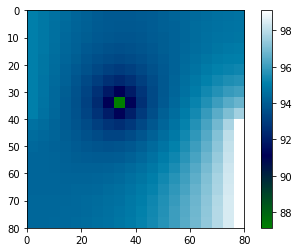

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# get all head data
head = sim.simulation_data.mfdata['mf6uzfexample', 'HDS', 'HEAD']
# get the head data from the end of the model run
head_end = head[-1]
# plot the head data from the end of the model run
extent = (0.0, 80.0, 80.0, 0.0)
#CS = plt.contour(head_end[0, :, :], extent=extent)
#plt.grid(head_end[0,:,:])
#plt.clabel(CS, inline=1, fontsize=10)
plt.imshow(head_end[0,:,:], interpolation='nearest', cmap=plt.cm.ocean, extent=extent)
plt.colorbar()
plt.show()

C:\WRDAPP\Miniconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


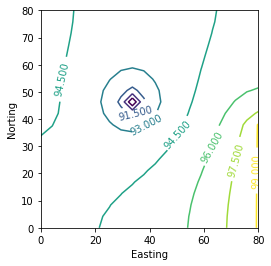

In [20]:
# get all head data
head = sim.simulation_data.mfdata['mf6uzfexample', 'HDS', 'HEAD']
# get the head data from the end of the model run
head_end = head[-1]
# plot the head data from the end of the model run
extent = (0.0, 80.0, 80.0, 0.0)
plt.subplot(111)
CS = plt.contour(head_end[0, :, :],extent=extent)
plt.xlabel('Easting')
plt.ylabel('Norting')
plt.clabel(CS, inline=1, fontsize=10)
plt.axes().set_aspect('equal')
plt.show()